In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten
from keras.layers import GRU

import numpy as np

from keras.callbacks import EarlyStopping 

from functions import Cleaning


Using TensorFlow backend.


In [2]:
df = pd.read_csv('re_fixed_multivariate_timeseires.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime'], inplace = True)

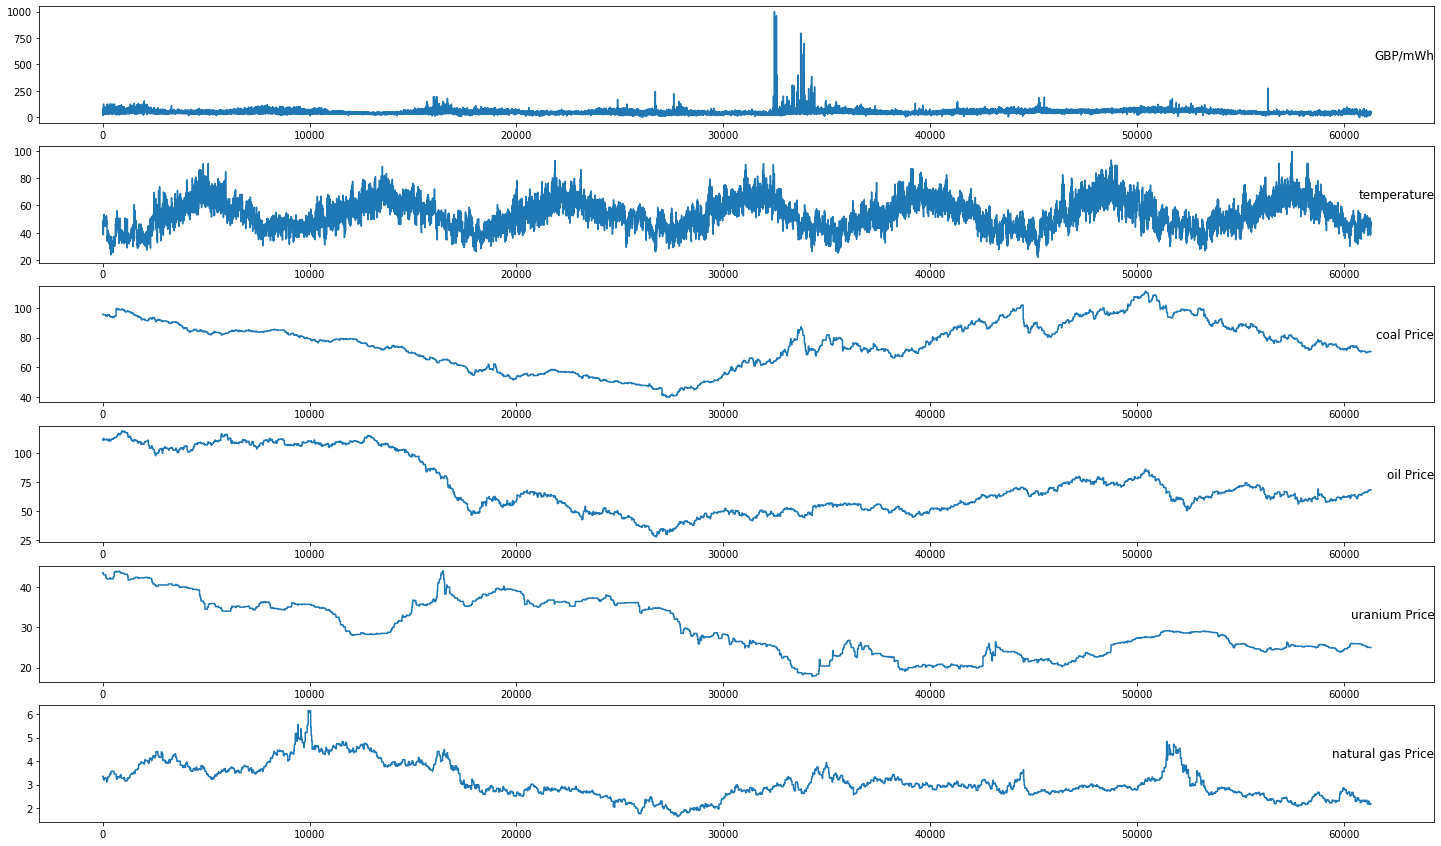

In [3]:
values = df.values

groups = [0, 1, 2, 3, 4, 5]
i = 1

# plot each column
plt.figure(figsize = (25, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [4]:
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)

scaled_df.shape

(61326, 6)

### Our current shape is simply the shape of the dataframe : 61326 rows by 6 features

#### Because this is a time series analysis, we must make time a dimension. We want each window of time to include the past week of values, and look forward to the next 24 hours as this is what the model will do. For every row (or hour) we now have a window of 192 hours, and 6 features, giving us a shape (61134, 192, 6)

In [5]:
data = scaled_df.values
n_steps = 168

In [6]:
series_reshaped =  np.array([data[i:i + (n_steps+24)].copy() for i in range(len(data) - (n_steps+24))])

In [7]:
series_reshaped.shape

(61134, 192, 6)

### Now that we have our data in this format, we need to split it so we have blocks of 168 hours (1 week) of every feature for the input data, and for every 168 block of hours, we have a 24 hour output, so our model can 'see' the next 24 hours

In [8]:
X_train = series_reshaped[:43800, :n_steps]
X_valid = series_reshaped[43800:52560, :n_steps]
X_test = series_reshaped[52560:, :n_steps]
Y = np.empty((61134, n_steps, 24))

for step_ahead in range(1, 24 + 1):
    Y[..., step_ahead - 1] = series_reshaped[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:43800]
Y_valid = Y[43800:52560]
Y_test = Y[52560:]

In [9]:
X_train.shape, Y_train.shape

((43800, 168, 6), (43800, 168, 24))

In [10]:
es = EarlyStopping(monitor = 'val_loss')

# Deep Multivariate Neural Network

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model6 = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 6]),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(24))
])

model6.compile(loss="mape", optimizer="adam")
history = model6.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), callbacks = [es])

Train on 43800 samples, validate on 8760 samples
43800/43800 [==============================] - 137s 3ms/sample - loss: 35.7181 - val_loss: 19.2607


In [13]:
dataframer = Cleaning()

In [14]:
dataframer = Cleaning()

Y_predDMNN = model6.predict(X_test)
DMNNdf = dataframer.nn_result_to_df(Y_predDMNN, X_test)

## Simple LSTM model

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

model8 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, return_sequences=True, input_shape=[None, 6]),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(24))
])

model8.compile(loss="mape", optimizer="adam")
history = model8.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), callbacks = [es])

Train on 43800 samples, validate on 8760 samples
Epoch 1/20


/Users/carterbouley/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/callbacks.py:497: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


AttributeError: 'ProgbarLogger' object has no attribute 'log_values'

In [ ]:
Y_predSLSTM = model6.predict(X_test)
SLSTMdf = dataframer.nn_result_to_df(Y_predSLSTM, X_test)

In [66]:
last_list=[]

for i in range (0, len(Y_pred)):
    last_list.append((Y_pred[i][0][23]))

In [67]:
predictions = pd.DataFrame(last_list)

In [68]:
actual = pd.DataFrame((X_test[:,0]))

In [70]:
actual = pd.DataFrame(actual[0])

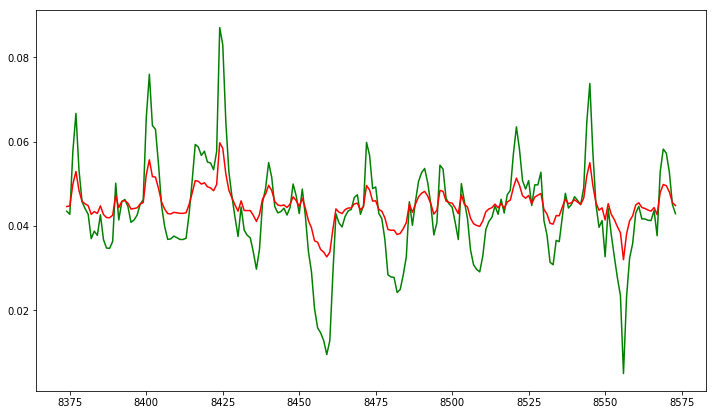

In [71]:
fig = plt.figure(figsize=(12,7))
plt.plot(actual[-200:], 'g')
plt.plot(predictions[-200:], 'r')

In [31]:
Y_train.shape

(43800, 168, 24)

In [32]:
Y_valid.shape

(8760, 168, 24)

In [36]:
Y_valid[0].shape

(168, 24)

In [39]:
Y_valid[0][2::].shape

(83, 24)

In [23]:
model = keras.models.Sequential([
    
keras.layers.TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 168, 6)),
keras.layers.TimeDistributed(MaxPooling1D(pool_size=2)),
keras.layers.TimeDistributed(Flatten()),
keras.layers.LSTM(50, activation='relu'),
keras.layers.Dense(1) ])

model.compile(loss="mape", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))


ValueError: Error when checking input: expected time_distributed_8_input to have 4 dimensions, but got array with shape (43800, 168, 6)

In [51]:
scaled_df[0][24::1]

24       0.034087
25       0.031692
26       0.030813
27       0.028597
28       0.032860
           ...   
61321    0.057834
61322    0.048351
61323    0.041833
61324    0.040476
61325    0.036992
Name: 0, Length: 61302, dtype: float64

In [55]:
Y_train.shape

(43800, 168, 24)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 6]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model.compile(loss="mape", optimizer="adam")
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 43800 samples, validate on 8760 samples
Epoch 1/20
43800/43800 [==============================] - 658s 15ms/step - loss: 18.8846 - val_loss: 14.8713
Epoch 2/20
43800/43800 [==============================] - 658s 15ms/step - loss: 13.6205 - val_loss: 12.3572
Epoch 3/20
43800/43800 [==============================] - 654s 15ms/step - loss: 12.0817 - val_loss: 11.0628
Epoch 4/20
43800/43800 [==============================] - 683s 16ms/step - loss: 11.4213 - val_loss: 10.5773
Epoch 5/20
24416/43800 [===============>..............] - ETA: 4:52 - loss: 11.1849

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

model9 = keras.models.Sequential([
    keras.layers.Conv1D(filters = 168, strides = 1, kernel_size = 2, padding = 'valid', input_shape=[None, 6]),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model9.compile(loss="mape", optimizer="adam")
# history = model9.fit(X_train, Y_train, epochs=5,
#                     validation_data=(X_valid, Y_valid))

In [98]:
model9.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, None, 168)         2184      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 168)         0         
_________________________________________________________________
gru_17 (GRU)                 (None, None, 20)          11340     
_________________________________________________________________
gru_18 (GRU)                 (None, None, 20)          2460      
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 24)          504       
Total params: 16,488
Trainable params: 16,488
Non-trainable params: 0
_________________________________________________________________


In [99]:
history = model9.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

InvalidArgumentError:  Incompatible shapes: [32,168,24] vs. [32,83,24]
	 [[node loss_14/time_distributed_17_loss/mean_absolute_percentage_error/sub (defined at /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_83536]

Function call stack:
keras_scratch_graph


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model8 = keras.models.Sequential([
    keras.layers.LSTM(168, return_sequences=True, input_shape=[None, 6]),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(84, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(42, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model8.compile(loss="mape", optimizer="adam")
history = model8.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))


Train on 43800 samples, validate on 8760 samples
Epoch 1/20
24256/43800 [===============>..............] - ETA: 7:01 - loss: 17.2709